In [1]:
# Python Chess Analysis Code v 05
# Dr. Matthew P. Tedesco July 2017
# The objective of this program is to generate an in depth game analysis
# In addition to traditional engine evaluations this program also provides metrics related to:
# 1) Material: Delta between sum of piece values for white and black
# 2) Development: Delta between the number of pieces (not pawns) no longer on their starting squares 
# 3) Mobility: Delta between the number of total legal moves
# 4) Control: Delta between the number of squares controlled by both sides.  This is associated with SPACE.
# 5) Tension (pressure): Delta between the number of attacking pieces for both sides
# 6) King safety: A weighted king tropism using the simple Chebyshev distance as the max of the 
#                 distance of the ranks or the files weighted based on piece values
#
# The program identifies innaccuracies, mistakes and blunders based on the engine evaluation cp deltas and also 
# indicates which side played a higher quality game overall based on the relative number of inaccuracies, mistakes, 
# and blunders.
#
# This early code assumes the PGN contains one game
#
# NOTE: This code relies on the python-chess library. You need to install the python-chess package.

import chess
import chess.engine
#import chess.uci as uci
import chess.pgn as pgn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import seaborn as sns

# KEY VARIABLES

#path = "D:/Dropbox/Python Projects/Chess Projects/" # set your working folder
pgnfile = r'test.pgn' # your pgn file
#enginepath = "D:/Dropbox/Python Projects/Chess Projects/" # path to your engine
enginefile = r"stockfish_20090216_x64" # engine file name
totaltime = 1 # total desired engine analysis time in minutes per game

# Thresholds in centipawns defining inaccuracy, mistake and blunder
inaccuracy = 30 
mistake = 90 
blunder = 200

# Piece Values in centipawns
pawn = 100
knight = 300
bishop = 300
rook = 500
queen = 900
king = 2500

# Open the pgn file

with io.open(pgnfile,encoding="utf-8-sig)") as pgnin:
    game = chess.pgn.read_game(pgnin)

In [2]:
# start performing the analysis

board = chess.Board()

#establish a dataframe to store my evaluations
gamedata = pd.DataFrame (
    columns =['Ply', 'Side' ,'Move', 'CP','Mate', 'CP Delta','Suggested','Depth', 'Material', \
              'Development', 'Mobility', 'Control', 'Tension', 'Safety'])

# loop through the game to count total plies (used to set analysis time)
node = game
plytotal = 1
while not node.is_end():
    next_node = node.variations[0]
    plytotal += 1 
    node = next_node

time = totaltime*60000/plytotal # sets associated analysis time per ply in milliseconds

# start chess engine
engine = chess.engine.SimpleEngine.popen_uci("stockfish_20090216_x64")
#engine.uci()
#info_handler = chess.uci.InfoHandler()
#engine.info_handlers.append(info_handler)
#info = engine.analyse(board, chess.engine.Limit(time=0.1))




# loop through the game ply by ply and populate the dataframe with evaluation data
node = game
cap = 30 # initial advantage for white is generally accepted as 30 centipawns
ply = 0
matedist = "N/A"

while not node.is_end():
    next_node = node.variations[0]
    move = node.board().san(next_node.move)
    if board.turn:
        side = "W"
    else:
        side = "B"
    
            
    capprior = cap
    
    # Do an engine evaluation of the position
    # can either set depth or movetime - I am setting movetime for predictable analysis times      
    #engine.analysis(board) 
    info = engine.analyse(board, chess.engine.Limit(time=0.1),multipv=10)
    #print(info[0]["score"])
    bestmove_score = info[0]["score"]
    
    try:
        second_bestmove_score = int(info[1]["score"].white().score() if(len(info) > 1) else 0)
    
    except:
        second_bestmove_score = 0
    
    
    try:
        third_bestmove_score = int(info[2]["score"].white().score() if(len(info) > 2) else 0)
    except:
        third_bestmove_score = 0
    try:
        worstmove_score = int(info[9]["score"].white().score() if(len(info) > 9) else 0)
    except:
        worstmove_score = 0 
        
    info = info[0]
    
    #print("currentmove_num: ",info[0]["currmovenumber"])
    #for info in info:
        #print("score: ",info["multipv"], info["score"])
    
    #
    bestmove = engine.analysis(board, chess.engine.Limit(time=0.1)).wait().move
    #print(bestmove)
    #print(bestmove)
    
    
    
    #bestmove = chess.engine.BestMove
    cap=info["score"].white().score()
    if(cap > 1000):
        cap = 1000
    elif(cap < -1000):
        cap = -1000
    
    #print(cap)
   # mate = cap.mate
    #if mate is not None:
        #matedist = mate
        #cap = mate/abs(mate)*king # set a very high cap if mate is on the board
    #else:
        #matedist = "N/A"
    depth=info["depth"]
    suggested = board.san(bestmove)  ## standard algebraic notation of the given move in the context of the current position.
    #if side == "B":
        #cap = - cap
    
    cpdelta = cap-capprior
    
    board.push(next_node.move) # calculate values based on the new position on the board
    
    # Material
    whitepawns = len(board.pieces(1,1))
    whiteknights = len(board.pieces(2,1))
    whitebishops = len(board.pieces(3,1))
    whiterooks = len(board.pieces(4,1))
    whitequeens = len(board.pieces(5,1))
    whiteking = len(board.pieces(6,1))
    whitematerial = pawn*whitepawns + knight*whiteknights + bishop*whitebishops + \
                    rook*whiterooks + queen*whitequeens +king*whiteking
    blackpawns = len(board.pieces(1,0))
    blackknights = len(board.pieces(2,0))
    blackbishops = len(board.pieces(3,0))
    blackrooks = len(board.pieces(4,0))
    blackqueens = len(board.pieces(5,0))
    blackking = len(board.pieces(6,0))
    blackmaterial = pawn*blackpawns + knight*blackknights + bishop*blackbishops + \
                    rook*blackrooks + queen*blackqueens +king*blackking
    material = whitematerial - blackmaterial
    
    # Development
    # Assess number of pieces no longer on starting squares for both sides
    whitedevelopment = 8
    blackdevelopment = 8
    if board.piece_at(chess.square(0,0)):
        if board.piece_at(chess.square(0,0)).symbol() == "R":
            whitedevelopment -= 1
    if board.piece_at(chess.square(1,0)):
        if board.piece_at(chess.square(1,0)).symbol() == "N":
            whitedevelopment -= 1
    if board.piece_at(chess.square(2,0)):
        if board.piece_at(chess.square(2,0)).symbol() == "B":
            whitedevelopment -= 1
    if board.piece_at(chess.square(3,0)):
        if board.piece_at(chess.square(3,0)).symbol() == "Q":
            whitedevelopment -= 1
    if board.piece_at(chess.square(4,0)):
        if board.piece_at(chess.square(4,0)).symbol() == "K":
            whitedevelopment -= 1
    if board.piece_at(chess.square(5,0)):
        if board.piece_at(chess.square(5,0)).symbol() == "B":
            whitedevelopment -= 1
    if board.piece_at(chess.square(6,0)):
        if board.piece_at(chess.square(6,0)).symbol() == "N":
            whitedevelopment -= 1
    if board.piece_at(chess.square(7,0)):
        if board.piece_at(chess.square(7,0)).symbol() == "R":
            whitedevelopment -= 1
    if board.piece_at(chess.square(0,7)):
        if board.piece_at(chess.square(0,7)).symbol() == "r":
            blackdevelopment -= 1
    if board.piece_at(chess.square(1,7)):
        if board.piece_at(chess.square(1,7)).symbol() == "n":
            blackdevelopment -= 1
    if board.piece_at(chess.square(2,7)):
        if board.piece_at(chess.square(2,7)).symbol() == "b":
            blackdevelopment -= 1
    if board.piece_at(chess.square(3,7)):
        if board.piece_at(chess.square(3,7)).symbol() == "q":
            blackdevelopment -= 1
    if board.piece_at(chess.square(4,7)):
        if board.piece_at(chess.square(4,7)).symbol() == "k":
            blackdevelopment -= 1
    if board.piece_at(chess.square(5,7)):
        if board.piece_at(chess.square(5,7)).symbol() == "b":
            blackdevelopment -= 1
    if board.piece_at(chess.square(6,7)):
        if board.piece_at(chess.square(6,7)).symbol() == "n":
            blackdevelopment -= 1
    if board.piece_at(chess.square(7,7)):
        if board.piece_at(chess.square(7,7)).symbol() == "r":
            blackdevelopment -= 1
    development = whitedevelopment - blackdevelopment 
    
    # Mobility
    # Calculate all legal moves for white and black
    mobility1 = board.legal_moves.count()
    # Change side to move by pushing a null move and calculate all moves for opponent
    board.push(chess.Move.null())
    mobility2 = board.legal_moves.count()
    # Take back the null move to reset the board back to the position
    board.pop()
    if side == "W":
        mobility = mobility2 - mobility1
    else:
        mobility = mobility1 - mobility2
        
    # Control
    # Control is closely associated with "Space"
    # We will calculate for every square the delta of white attackers to black attackers and sum the deltas
    whitecontrol = 0
    blackcontrol= 0
    for spacesquare in range (64):
        whitecontrol += len(board.attackers(chess.WHITE, spacesquare))
        blackcontrol += len(board.attackers(chess.BLACK, spacesquare))
    control = whitecontrol - blackcontrol
        
    # Tension (or Pressure)
    # very simplistic right now - just a delta of # of attacked pieces for black vs. white
    # when a piece is attacked by the opposing color
        
    spacesquare = 0
    tensionwhite = 0
    tensionblack = 0
    tension = 0
    for spacesquare in range(64):
        if board.piece_at(spacesquare):
            if board.piece_at(spacesquare).symbol() == "K":
                whitekingsquare = spacesquare # used later for king safety
            if board.piece_at(spacesquare).symbol() == "k":
                blackkingsquare = spacesquare # used later for king safety
            if board.piece_at(spacesquare).color == chess.BLACK:
                if board.is_attacked_by(chess.WHITE, spacesquare):
                    tensionwhite += 1
            if board.piece_at(spacesquare).color == chess.WHITE:
                if board.is_attacked_by(chess.BLACK, spacesquare):
                    tensionblack +=1
    tension = tensionwhite - tensionblack
    
    # King Safety
    # This could get very complicated.  I will keep it simple for now.
    # As a simple check, I will calculate safety based on a weighted tropism/distance.
    
    if whitekingsquare <= 7:    # start figuring out the rank and file for the white king
        whiterank = 0
    elif  whitekingsquare > 7 and whitekingsquare <= 15:
        whiterank = 1
    elif whitekingsquare >15 and whitekingsquare <= 23:
        whiterank = 2
    elif whitekingsquare >23 and whitekingsquare <= 31:
        whiterank = 3
    elif whitekingsquare >31 and whitekingsquare <= 39:
        whiterank = 4
    elif whitekingsquare >39 and whitekingsquare <= 47:
        whiterank = 5
    elif whitekingsquare >47 and whitekingsquare <= 55:
        whiterank = 6
    elif whitekingsquare >55 and whitekingsquare <= 63:
        whiterank = 7
    whitefile = whitekingsquare - whiterank*7 - whiterank

        
    if blackkingsquare <= 7:    # start figuring out the rank and file of the black king
        blackrank = 0
    elif  blackkingsquare > 7 and blackkingsquare <= 15:
        blackrank = 1
    elif blackkingsquare >15 and blackkingsquare <= 23:
        blackrank = 2
    elif blackkingsquare >23 and blackkingsquare <= 31:
        blackrank = 3
    elif blackkingsquare >31 and blackkingsquare <= 39:
        blackrank = 4
    elif blackkingsquare >39 and blackkingsquare <= 47:
        blackrank = 5
    elif blackkingsquare >47 and blackkingsquare <= 55:
        blackrank = 6
    elif blackkingsquare >55 and blackkingsquare <= 63:
        blackrank = 7
    blackfile = blackkingsquare - blackrank*7 - blackrank
    
    
    # now we will loop through all the squares and calculate the sum of the distances x piece values
    # I am using the simple Chebyshev distance as the max of the distance of the ranks or the files
    distancesquare = 0
    whitesafety = 0
    blacksafety = 0
    blackattacked = 0
    whiteattacked = 0
    wmat = 0
    bmat = 0
    whiteratio = 0
    blackratio = 0
    for distancesquare in range (64):
        if board.piece_at(distancesquare):
            P = board.piece_at(distancesquare).symbol()
        else:
            P = ""
        if distancesquare <= 7:    # figuring out the rank and file
            distancerank = 0
        elif  distancesquare > 7 and distancesquare <= 15:
            distancerank = 1
        elif distancesquare >15 and distancesquare <= 23:
            distancerank = 2
        elif distancesquare >23 and distancesquare <= 31:
            distancerank = 3
        elif distancesquare >31 and distancesquare <= 39:
            distancerank = 4
        elif distancesquare >39 and distancesquare <= 47:
            distancerank = 5
        elif distancesquare >47 and distancesquare <= 55:
            distancerank = 6
        elif distancesquare >55 and distancesquare <= 63:
            distancerank = 7
        distancefile = distancesquare - distancerank*7 - distancerank
        whitedistance = max(abs(whiterank-distancerank), abs(whitefile-distancefile))
        blackdistance = max(abs(blackrank-distancerank), abs(blackfile-distancefile))
        if P == "R":
            blackattacked += rook*blackdistance
            whitesafety += rook*whitedistance
            wmat += rook
        elif P == "B":
            blackattacked += bishop*blackdistance
            whitesafety += bishop*whitedistance
            wmat += bishop
        elif P=="N":
            blackattacked += knight*blackdistance
            whitesafety += knight*whitedistance
            wmat += knight
        elif P=="Q":
            blackattacked += queen*blackdistance
            whitesafety += queen*whitedistance
            wmat += queen
        elif P =="P":
            blackattacked += pawn*blackdistance
            whitesafety += pawn*whitedistance
            wmat += pawn
        elif P == "r":
            blacksafety += rook*blackdistance
            whiteattacked += rook*whitedistance
            bmat +=rook
        elif P == "n":
            blacksafety += knight*blackdistance
            whiteattacked += knight*whitedistance
            bmat +=knight
        elif P == "b":
            blacksafety += bishop*blackdistance
            whiteattacked += bishop*whitedistance
            bmat +=bishop
        elif P=="q":
            blacksafety += queen*blackdistance
            whiteattacked += queen*whitedistance
            bmat += queen
        elif P =="p":
            blacksafety += pawn*blackdistance
            whiteattacked += pawn*whitedistance
            bmat += pawn
    
    # see if king in check and make adjustment to the attacked values adding king value less queen value
    # for each legal king move - this is somewhat arbitrary but intended to penalize a king in check but 
    # reduce the penalty of the king is mobile
    legal = str(board.legal_moves).count("K") + str(board.legal_moves).count("k")
    if board.is_check():
        if side == "W":
            whiteattacked += king - queen*legal
        else:
            blackattacked += king - queen*legal
    
    whiteratio = (whitesafety - whiteattacked)/bmat
    blackratio = (blacksafety - blackattacked)/wmat
    safety = blackratio - whiteratio
           
    movedata = pd.DataFrame([(ply, side, move, cap, matedist, cpdelta, suggested, second_bestmove_score, third_bestmove_score, worstmove_score, depth, material, \
                              development, mobility, control, tension, safety)], \
                              columns =['Ply', 'Side', 'Move', 'CP','Mate', 'CP Delta',\
                              'Suggested','Second move score', 'Third move score', 'Worst move score','Depth','Material', 'Development', 'Mobility', 'Control', \
                              'Tension', 'Safety'])
    
    gamedata = gamedata.append(movedata, ignore_index=True)
     
    ply += 1 
    node = next_node

engine.quit()


# Now we need to shift the engine evaluation columns by one in gamedata to align to the played and suggested moves
gamedata['CP'] = gamedata['CP'].shift(-1)
gamedata['CP Delta'] = gamedata['CP Delta'].shift(-1)

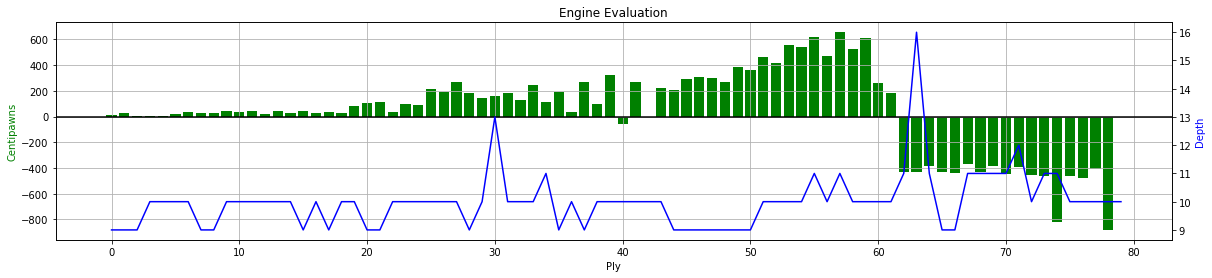

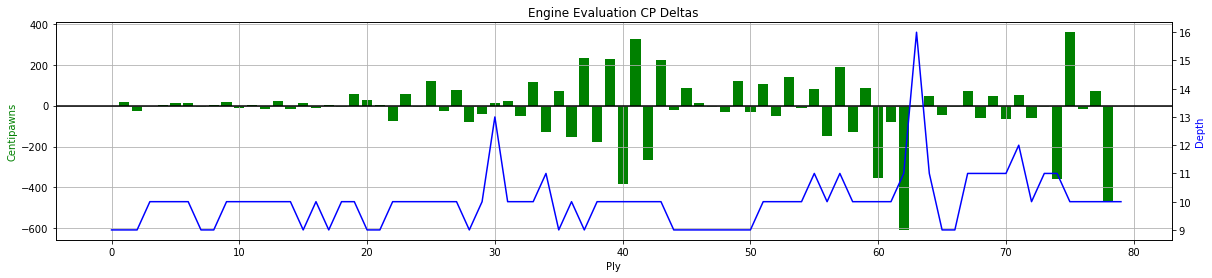

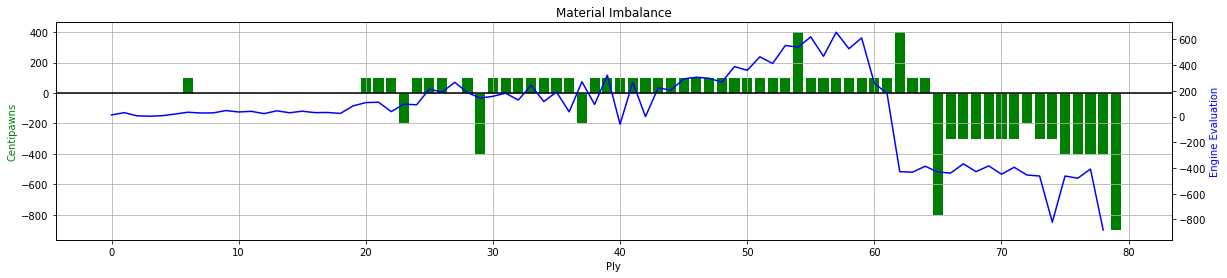

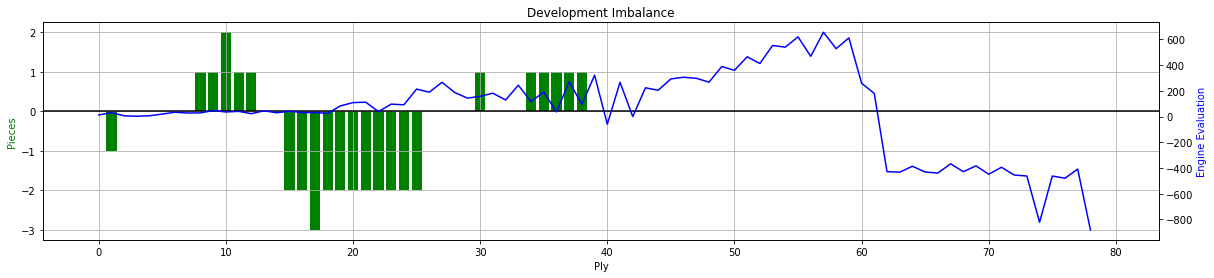

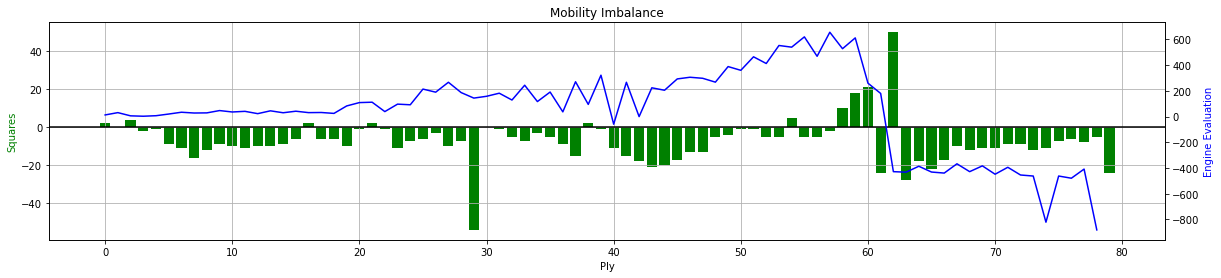

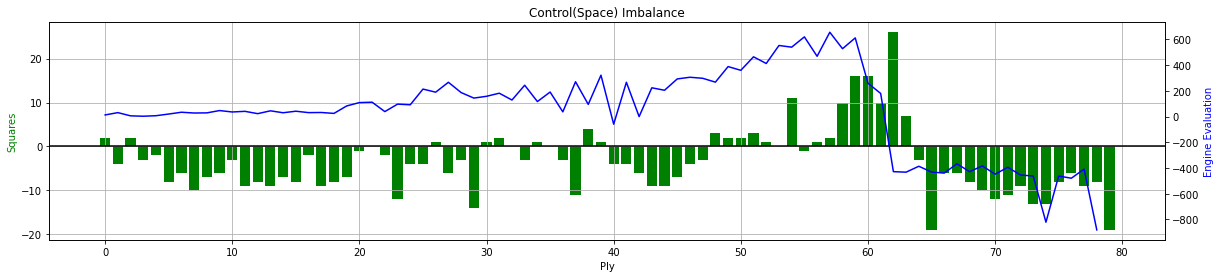

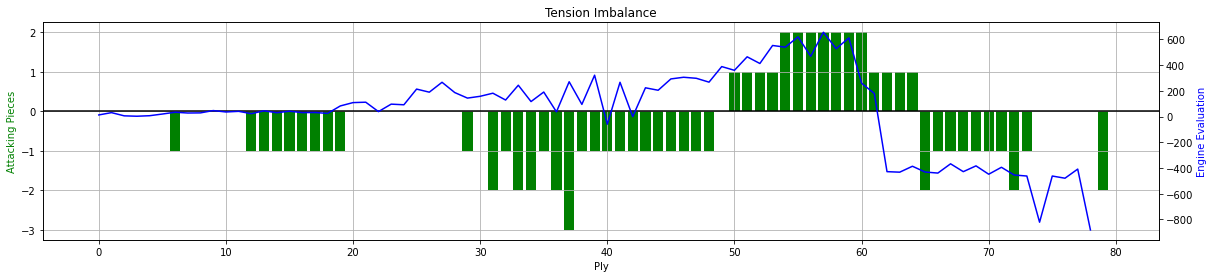

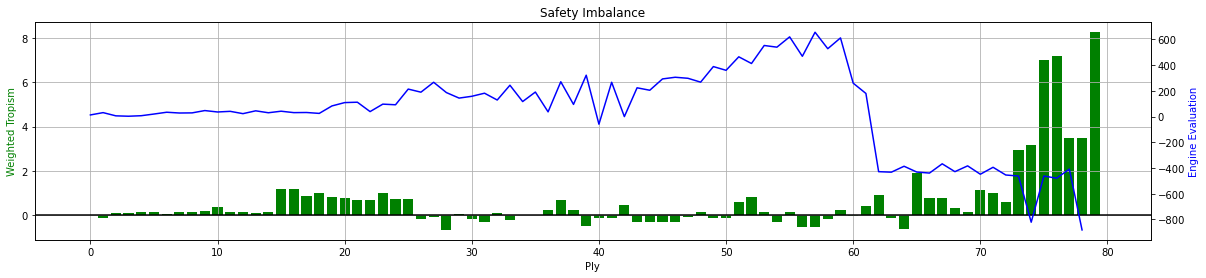

In [3]:
# Generate evaluation profile bar plots by ply
y = gamedata['CP']
z = gamedata['Depth']
x = gamedata['Ply']

#freq = round(max(x)/50,0) # If the game has so many moves that the labels would overlap, change frequency
#frequency = int(freq)
#print(frequency)

#print(gamedata['Ply'])
plt.figure(figsize=(20,4))
plt.ylabel ('Centipawns', color = 'green')
plt.bar (x,y,color = 'green')
#plt.xticks (x[::frequency])
plt.xlabel ('Ply')
plt.axhline(0, color='black')
plt.grid()
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Depth', color = 'blue')
plt.title('Engine Evaluation')
plt.show()

y = gamedata['CP Delta']
z = gamedata['Depth']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Centipawns', color = 'green')
plt.xlabel ('Ply')
#plt.xticks (x[::frequency])
plt.title('Engine Evaluation CP Deltas')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Depth', color = 'blue')
plt.show()

y = gamedata['Material']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Centipawns', color = 'green')
plt.xlabel ('Ply')
#plt.xticks (x[::frequency])
plt.title('Material Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Development']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Pieces', color = 'green')
plt.xlabel ('Ply')
#plt.xticks (x[::frequency])
plt.title('Development Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Mobility']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Squares', color = 'green')
plt.xlabel ('Ply')
#plt.xticks (x[::frequency])
plt.title('Mobility Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Control']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Squares', color = 'green')
plt.xlabel ('Ply')
#plt.xticks (x[::frequency])
plt.title('Control(Space) Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Tension']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Attacking Pieces', color = 'green')
plt.xlabel ('Ply')
#plt.xticks (x[::frequency])
plt.title('Tension Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Safety']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Weighted Tropism', color = 'green')
plt.xlabel ('Ply')
#plt.xticks (x[::frequency])
plt.title('Safety Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()


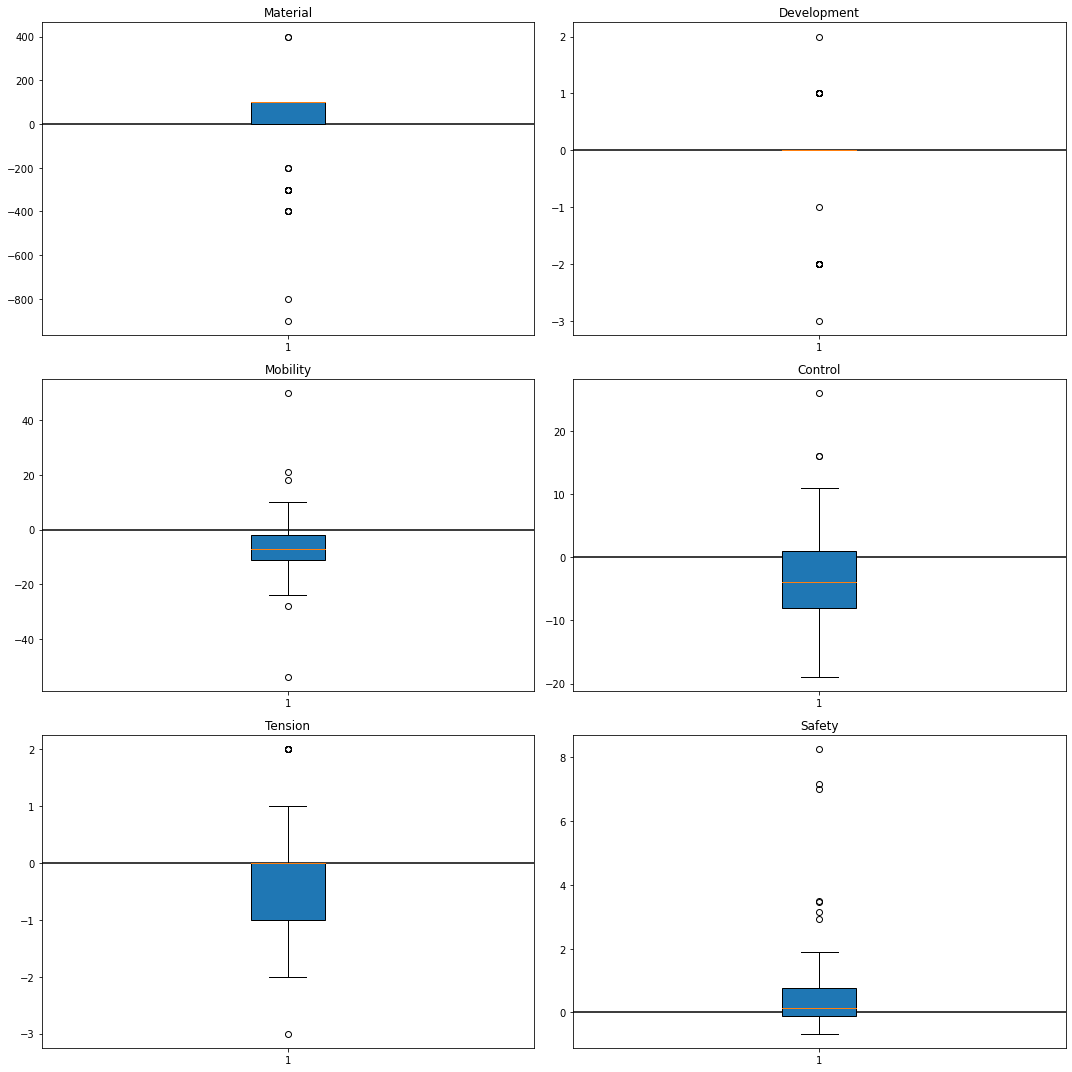

In [4]:
fig,((matbox,devbox),(mobbox,conbox),(tenbox,safbox)) = plt.subplots(nrows=3, ncols=2, figsize =(15,15))
matbox.boxplot(gamedata['Material'], patch_artist=True)
matbox.set_title('Material')
matbox.axhline(0, color='black')
devbox.boxplot(gamedata['Development'], patch_artist=True)
devbox.set_title('Development')
devbox.axhline(0, color='black')
mobbox.boxplot(gamedata['Mobility'], patch_artist=True)
mobbox.set_title('Mobility')
mobbox.axhline(0, color='black')
conbox.boxplot(gamedata['Control'], patch_artist=True)
conbox.set_title('Control')
conbox.axhline(0, color='black')
tenbox.boxplot(gamedata['Tension'], patch_artist=True)
tenbox.set_title('Tension')
tenbox.axhline(0, color='black')
safbox.boxplot(gamedata['Safety'], patch_artist=True)
safbox.set_title('Safety')
safbox.axhline(0, color='black')
plt.tight_layout()
plt.show()

In [6]:
# Identify innacuracies, mistakes, and blunders and store in a new dataframe

errors = pd.DataFrame (columns =['Ply', 'Side' ,'Move', 'CP', 'CP Delta', 'TypeOfMistake', 'Suggested', 'score1', 'score2', 'score3','Depth'])

for index,row in gamedata.iterrows():
    if row['Side'] == "B":
        if row['CP Delta'] > blunder:
            typeOfMist = 'Blunder'
        elif row['CP Delta'] > mistake:
            typeOfMist = 'Mistake'
        elif row['CP Delta'] > inaccuracy:
            typeOfMist = 'Inaccuracy'
        if row['CP Delta'] > inaccuracy:
            movedata = pd.DataFrame([(row['Ply'], row['Side'], row['Move'], row['CP'], row['CP Delta'],\
                                      typeOfMist, row['Suggested'], row['Second move score'], row['Third move score'], row['Worst move score'], row['Depth'])], columns =['Ply', 'Side', \
                                      'Move', 'CP','CP Delta', 'TypeOfMistake','Suggested','score1', 'score2', 'score3','Depth'])

            errors = errors.append(movedata, ignore_index=True)
            
    if row['Side'] == "W":
        if row['CP Delta'] < -blunder:
            typeOfMist = 'Blunder'
        elif row['CP Delta'] < -mistake:
            typeOfMist = 'Mistake'
        elif row['CP Delta'] < -inaccuracy:
            typeOfMist = 'Inaccuracy'
        if row['CP Delta'] < -inaccuracy:
            movedata = pd.DataFrame([(row['Ply'], row['Side'], row['Move'], row['CP'], row['CP Delta'],\
                                      typeOfMist, row['Suggested'], row['Second move score'], row['Third move score'], row['Worst move score'],row['Depth'])], columns =['Ply', 'Side', \
                                      'Move', 'CP','CP Delta', 'TypeOfMistake','Suggested','score1', 'score2', 'score3', 'Depth'])

            errors = errors.append(movedata, ignore_index=True)                     

            
#summary of inaccuracies, mistakes and blunders in errors dataframe
pd.options.display.max_rows=1000
errors

,Ply,Side,Move,CP,CP Delta,TypeOfMistake,Suggested,score1,score2,score3,Depth
0,19,B,Nd4,83,58,Inaccuracy,f6,31.0,51.0,105.0,10
1,22,W,f4,39,-73,Inaccuracy,f4,-47.0,-36.0,-312.0,10
2,23,B,Bxe5,97,58,Inaccuracy,Nd5,71.0,76.0,191.0,10
3,25,B,f6,214,122,Mistake,Nd5,121.0,138.0,159.0,10
4,27,B,fxe5,267,77,Inaccuracy,Nf5,193.0,223.0,251.0,10
5,28,W,Bxb7,187,-80,Inaccuracy,Rxf8+,89.0,86.0,-42.0,9
6,32,W,Bg2,129,-53,Inaccuracy,Bg2,143.0,120.0,-348.0,10
7,33,B,Nd5,244,115,Mistake,Qd7,136.0,150.0,294.0,10
8,34,W,Bd2,117,-127,Mistake,Ne4,283.0,248.0,-306.0,11
9,35,B,Nf6,191,74,Inaccuracy,Qd7,163.0,169.0,285.0,9


In [8]:
# Calculate play quality based on % of moves that are NOT innacuracies, mistakes, or blunders by deducting points
# for each and define quality as a precentage based on max possible points.

# Define scoring system as decuctions out of a total possible 10 points per move
# This could be refined further in the future to skip opening moves and treat forced moves differently
isc = -2
msc = -5
bsc = -10
whiteinaccuracies = 0
whitemistakes = 0
whiteblunders = 0
blackinaccuracies = 0
blackmistakes = 0
blackblunders = 0

totalwhite = len(gamedata[gamedata['Side']== "W"])*10
totalwhitescore = totalwhite
totalblack = len(gamedata[gamedata['Side']== "B"])*10
totalblackscore = totalblack


for index,row in errors.iterrows():
    if row['Side'] == "B":
        if row['TypeOfMistake'] == "Inaccuracy":
            totalblackscore += isc
            blackinaccuracies +=1
        elif row['TypeOfMistake'] == "Mistake":
            totalblackscore += msc
            blackmistakes +=1
        elif row['TypeOfMistake'] == "Blunder":
            totalblackscore += bsc
            blackblunders +=1
    if row['Side'] == "W":
        if row['TypeOfMistake'] == "Inaccuracy":
            totalwhitescore += isc
            whiteinaccuracies +=1
        elif row['TypeOfMistake'] == "Mistake":
            totalwhitescore += msc
            whitemistakes +=1
        elif row['TypeOfMistake'] == "Blunder":
            totalwhitescore += bsc
            whiteblunders +=1
        
            
whitequality = float(totalwhitescore)/float(totalwhite)
blackquality = float(totalblackscore)/float(totalblack)            

print ("Event:",game.headers["Event"])
print ("Site:",game.headers["Site"])
print ("Date:",game.headers["Date"])
print ("Round:",game.headers["Round"])
print ("White:",game.headers["White"])
print ("Black:",game.headers["Black"])
print ("Result:",game.headers["Result"])
print ("Quality of White Play:",round(whitequality*100,0),"%")
print ("White made",whiteinaccuracies,"inaccuracies,",whitemistakes,"mistakes, and", whiteblunders,"blunders.")
print ("Quality of Black Play:",round(blackquality*100,0),"%")
print ("Black made",blackinaccuracies,"inaccuracies,",blackmistakes,"mistakes, and", blackblunders,"blunders.")


pgnin.close()

Event: Leon 30th
Site: Leon
Date: 2017.07.09
Round: 2.5
White: So, Wesley
Black: Anand, Viswanathan
Result: 1-0
Quality of White Play: 75.0 %
White made 7 inaccuracies, 5 mistakes, and 6 blunders.
Quality of Black Play: 74.0 %
Black made 11 inaccuracies, 6 mistakes, and 5 blunders.


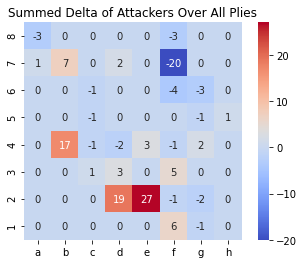

In [67]:
# Sum of white attackers less black attackers for each occupied square that is under attack

with io.open(pgnfile,encoding="utf-8-sig)") as pgnin:
    game = chess.pgn.read_game(pgnin)

board = chess.Board()
node = game

#establish a dataframe to store my evaluations
attackedlist = pd.DataFrame(index=range(0,64), columns=range(0,ply))
attackedmap = pd.DataFrame(index = [8,7,6,5,4,3,2,1],columns =[1,2,3,4,5,6,7,8])



# loop through the game to count for each occupied square for each ply
ply = 0
while not node.is_end():
    next_node = node.variations[0]
    node = next_node
    board.push(next_node.move)
    
    for spacesquare in range(64):
        attackers = 0 
        if board.piece_at(spacesquare):
            if board.piece_at(spacesquare).color == chess.BLACK:
                if board.is_attacked_by(chess.WHITE, spacesquare):
                        attackers = len(board.attackers(chess.WHITE, spacesquare))-\
                                    len(board.attackers(chess.BLACK, spacesquare))
            if board.piece_at(spacesquare).color==chess.WHITE:
                if board.is_attacked_by(chess.BLACK, spacesquare):
                        attackers = len(board.attackers(chess.WHITE, spacesquare))-\
                                    len(board.attackers(chess.BLACK, spacesquare))      
            attackedlist.at[spacesquare,ply] = attackers       
    ply += 1

plytotal = ply

attackedlist['sum'] = attackedlist.sum(axis=1)

ply = 0
for ply in range (plytotal):
    for spacesquare in range (64):
        
        attackedmap.at[chess.square_rank(spacesquare)+1,chess.square_file(spacesquare)+1] = attackedlist.iloc[spacesquare, ply+1]

attackedmap = attackedmap.astype(float)            
sns.heatmap(attackedmap, cmap="coolwarm", annot = True, fmt = '.0f', square = True, \
xticklabels = ['a','b','c','d','e','f','g','h'])
plt.title("Summed Delta of Attackers Over All Plies")
plt.show()

    
pgnin.close()



In [ ]:
#%%cmd
#git clone https://github.com/CYHSM/chess-surprise-analysis.git

In [56]:
# %load chess-surprise-analysis/csa/csa.py
"""
csa : Chess Surprise analysis
author : Markus Frey
e-mail : markus.frey1@gmail.com
github : https://github.com/CYHSM/chess-surprise-analysis
"""
import chess.pgn
#import chess.uci
import chess.engine
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio


###############################################################################
#####################LOAD GAME AND BOARD#######################################
###############################################################################
def load_engine(engine_options=None):
    """Load engine for analysing games"""
    # Use the open-soure engine Stockfish
    engine = chess.engine.SimpleEngine.popen_uci("stockfish_20090216_x64")
    # Important to use UCI (Universal Chess Interface)
    #engine.uci()
    if engine_options:
        engine.setoption(engine_options)
    # Use an InfoHandler to save information about the analysis
    info = engine.analysis(board, chess.engine.Limit(time=0.1))
    #engine.info.append(info_handler)

    return engine, info


def reset_present_engine(engine, engine_options=None):
    """Reset the engine to avoid usage of hashtables in evaluation.

    Problem: After first analysis a lot of possible moves are stored in
        the hashtable so a re-run on low depths will lead to evaluations
        based on higher depths

    """
    #engine.quit()
    #engine= engine.configure(engine_options)

    return engine


def load_game_from_pgn(path_to_pgn):
    """Read a chess game from PGN"""
    # Open and close PGN file
    with open(path_to_pgn) as pgn_file:
        # Read game information
        chess_game = chess.pgn.read_game(pgn_file)

    return chess_game


def get_board_at_position(chess_game, halfmove_number):
    """
    Given a chess game, returns the board at given halfmove_number
    """
    halfmove_counter = 1
    while not chess_game.is_end() and halfmove_counter - 1 < halfmove_number:
        board = chess_game.board()
        next_node = chess_game.variation(0)
        chess_game = next_node
        halfmove_counter += 1
    return board


###############################################################################
#####################GAME EVALUATION###########################################
###############################################################################
def evaluate_game(chess_game, halfmove_numbers=None, reset_engine=True,
                  depths=range(5, 20), verbose=0, async_callback=False,
                  fillna=True, engine_options=None):
    """
    Evaluate each move of the game

    Inputs:
    - chess_game : The game to analyse
    - halfmove_numbers : Specify the move numbers which should be analysed,
                    None analyses all
    - reset_engine : Boolean if engine should be reset during moves,
                        otherwise will lead to different results due to hashing
    - depths : Specify the depths which should be analysed
    - verbose : Specify if output should be printed (0,1)
    - async_callback : Boolean if calculation should be performed asynchrone

    Outputs:
    - cp_per_move : Centipawn evaluation over all depths per move
    - nodes_per_move : How many nodes were evaluated over all depths per move

    """
    # Initialise Outputs
    cp_per_move = {}
    nodes_per_move = {}
    halfmove_counter = 1
    # Get engine
    engine, info = load_engine(engine_options)
    # Loop over all moves
    while not chess_game.is_end():
        board = chess_game.board()
        next_node = chess_game.variation(0)
        chess_game = next_node
        if halfmove_numbers is not None:
            if halfmove_counter not in halfmove_numbers:
                halfmove_counter += 1
                continue
        # Reset engine
        if reset_engine:
            engine = reset_present_engine(engine, engine_options=engine_options)
        # Evaluate board
        if verbose:
            print('Evaluating half-move %d, Depth: ' %
                  halfmove_counter, end='')
        if async_callback:
            cp_per_depth, nodes_per_depth = evaluate_board_asynchrone(
                board, engine, max_depth=np.max(depths), verbose=verbose)
        else:
            cp_per_depth, nodes_per_depth = evaluate_board(
                board, engine, depths=depths, verbose=verbose)
        # Save Outputs
        cp_per_move[halfmove_counter] = cp_per_depth
        nodes_per_move[halfmove_counter] = nodes_per_depth
        halfmove_counter += 1
        if verbose:
            print('')
    # Return as dataframe
    cp_per_move = pd.DataFrame.from_dict(cp_per_move)
    nodes_per_move = pd.DataFrame.from_dict(cp_per_move)
    # Fill Nan Values as asynchrone evaluation skips depths
    if fillna:
        cp_per_move = cp_per_move.fillna(method='pad').fillna(method='bfill')
        nodes_per_move = nodes_per_move.fillna(method='pad').fillna(method='bfill')

    return cp_per_move, nodes_per_move


def evaluate_board(board, engine, depths=range(5, 20), verbose=0):
    """
    Evaluates the current position on the board

    Inputs:
    - board: Contains all the information about the position of the pieces
    - engine: Engine used to evaluate Position

    Outputs:
    - cp_per_depth: Centipawn Evaluation per depth used
    - nodes_per_depth: How many nodes where evaluated at this depth
    """
    # Initialise Outputs
    cp_per_depth = {}
    nodes_per_depth = {}
    # Set board position
    #engine.position(board)
    for depth in depths:
        if verbose:
            print('%d,' % depth, end='')
        
        #if(type(engine) is tuple):
            #engine=engine[0]
        
        info = engine.analyse(board, chess.engine.Limit(depth=depth))  # Run analysis
        centipawn_eval = info["score"].white().score()  # Get evaluation from info_handler
        # Catch problems with the evaluation
        if centipawn_eval is None:
            centipawn_eval = np.NaN
        # Make sure the evaluation is not dependent on the side to move
        if not board.turn:
            centipawn_eval *= -1
        cp_per_depth[depth] = centipawn_eval
        nodes_per_depth[depth] = info["nodes"]
    return cp_per_depth, nodes_per_depth


def evaluate_board_asynchrone(board, engine, max_depth=20, verbose=0):
    """
    Evaluates the current position on the board in an asynchrone way

    Inputs:
    - board: Contains all the information about the position of the pieces
    - engine: Engine used to evaluate Position

    Outputs:
    - cp_per_depth: Centipawn Evaluation per depth used
    - nodes_per_depth: How many nodes where evaluated at this depth
    """
    # Initialise Outputs
    cp_per_depth = {}
    nodes_per_depth = {}
    current_depth = 1

    # Set board position
    #engine.position(board)
    info = engine.analyse(chess.engine.Limit(depth=max_depth))
    while current_depth != max_depth:
        if 1 in info["score"]:
            centipawn_eval = info[
                "score"].white().score()  # Get evaluation from info_handler
            # Catch problems with the evaluation
            if centipawn_eval is None:
                centipawn_eval = np.NaN
            # Make sure the evaluation is not dependent on the side to move
            if not board.turn:
                centipawn_eval *= -1
            if current_depth != info["depth"]:
                current_depth = info["depth"]
                if verbose:
                    print('%d,' % current_depth, end='')
            # Save values
            cp_per_depth[current_depth] = centipawn_eval
            if 'nodes' in info:
                nodes_per_depth[current_depth] = info["nodes"]
    engine.stop()
    return cp_per_depth, nodes_per_depth


def analyse_evaluations(cp_df, low=5, high=11, end=None, use_log=True):
    """
    Analyses evaluations and returns 'surprise' scores

    Inputs:
    - cp_df : Dataframe of evaluations in centipawns.
            Dimensions: #Depths x #Moves
    - low : Human range of chess ;)
    - high : Computer range ;)

    Outputs:
    - ss_df : Dataframe with surprise scores. Dimension: #Moves
    - infos : Dict with additional parameters
    """
    infos = {}
    low_mean = cp_df[low:high].mean()
    if end is not None:
        high_mean = cp_df[high + 1:end].mean()
    else:
        high_mean = cp_df[high + 1::].mean()
    if use_log:
        # Be aware of 0 division if using logarithmic identity : log(a/b) = log(a) - log(b)
        # Here we use masked numpy array to fix zero values
        low_log = np.ma.log(np.abs(low_mean.values)).data * np.sign(low_mean.values)
        high_log = np.ma.log(np.abs(high_mean.values)).data * np.sign(high_mean.values)
        ss_df = pd.DataFrame(low_log - high_log, index=cp_df.columns)
        infos['low_log'] = low_log
        infos['high_log'] = high_log
    else:
        ss_df = low_mean - high_mean
    infos['low_mean'] = low_mean
    infos['high_mean'] = high_mean

    return ss_df, infos


###############################################################################
#####################SAVE EVALUATIONS##########################################
###############################################################################
def save_evaluation(cp, nodes, depths, async_callback,
                    reset_engine, name):
    """
    Saves the evaluations with other information in a file

    Inputs:
    - cp : Dataframe of evaluations in centipawns.
            Dimensions: #Depths x #Moves
    - nodes : Dataframe of how many nodes were evaluated at which depth
    - depths : How far did the engine calculate
    - reset_engine : Boolean if engine was reset during moves,
                    otherwise will lead to different results due to hashing
    - async_callback : Boolean if calculation should be performed asynchrone
    - name : Specify as year_opponent1_opponent2
    """
    # Construct dict for saving
    obj = {}
    obj['cp'] = cp
    obj['nodes'] = nodes
    obj['depths'] = depths
    obj['async_callback'] = async_callback
    obj['reset_engine'] = reset_engine
    # Save to file
    base_dir = r'C:\Users\Adam\evaluations'
    name = 'test_surprise'
    with open(base_dir +'\\'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def plot_cp(cp, fn='test.svg', save=True, low=12):
    # Truncate values
    cp_trunc = cp.copy()
    cp_trunc[np.abs(cp_trunc) > 100] = 100 * np.sign(cp_trunc)
    fig, ax = plt.subplots(figsize=(20,4))
    sns_plot = sns.heatmap(np.flipud(cp_trunc.loc[low::,:]), ax=ax, linecolor="black", linewidths=0.1, cmap="RdBu_r")
    #sns_plot = sns.heatmap(np.flipud(cp_trunc), ax=ax, linecolor="black", linewidths=0.1, cmap="RdBu_r")
    xtick_vec = np.arange(1, cp.shape[1], step=5)
    sns_plot.set(xticks=xtick_vec, xticklabels=xtick_vec, yticklabels=[], ylabel='Depth', xlabel='Half-Move Number')
    fig.subplots_adjust(bottom=0.20)
    #sns_plot.set()
    if save:
        sns_plot.figure.savefig('./media/'+fn, transparent=True)


def load_evaluation(name):
    """
    Load the evaluations with other informations from file

    Inputs:
    - name : Name of file, in format year_opponent1_opponent2

    Outputs:
    - cp : Dataframe of evaluations in centipawns.
            Dimensions: #Depths x #Moves
    - nodes : Dataframe of how many nodes were evaluated at which depth
    - depths : How far did the engine calculate
    - reset_engine : Boolean if engine was reset during moves,
                    otherwise will lead to different results due to hashing
    - async_callback : Boolean if calculation should be performed asynchrone
    - name : Specify as year_opponent1_opponent2
    """
    # Load from file
    base_dir = r'/evaluations/'
    with open(base_dir + name + '.pkl', 'rb') as f:
        obj = pickle.load(f)
    cp = obj['cp']
    nodes = obj['nodes']
    depths = obj['depths']
    async_callback = obj['async_callback']
    reset_engine = obj['reset_engine']
    # Return
    return cp, nodes, depths, async_callback, reset_engine


Evaluating half-move 1, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 2, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 3, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 4, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 5, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 6, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 7, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 8, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 9, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 10, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 11, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 12, Depth: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Evaluating half-move 13, Depth: 1,2,3

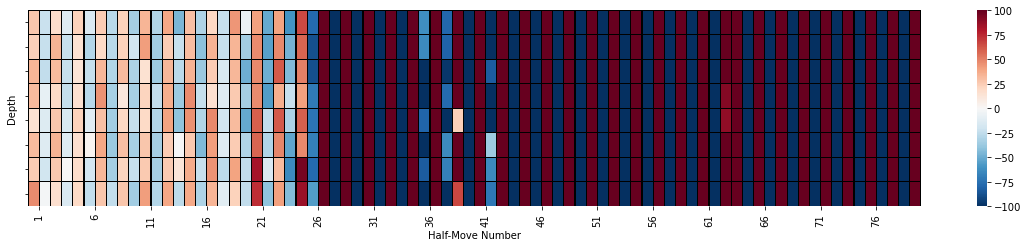

In [57]:
import asyncio
# Load Game from PGN
path_to_pgn = r'test.pgn'
chess_game = load_game_from_pgn(path_to_pgn)
# Evaluate Game
#asyncio.set_event_loop_policy(chess.engine.EventLoopPolicy())
cp, nodes = evaluate_game(chess_game, reset_engine=True,
                              halfmove_numbers=None, depths=range(1, 20),
                              verbose=1)

# Save cp
save_evaluation(cp, nodes, range(1, 13), True,
                    True, 'test_surprise')
# Plot heatmap
plot_cp(cp, fn='test.svg', save=False)

# Find surprising moves
ss_df, infos = analyse_evaluations(cp, low=12, high=20)

In [95]:
import re
from collections import Counter
## TODO: number of moves with each piece (use regex)
def number_of_piece_moves(pgnin):
    #syntax: . P , ... P, /d P, 
    with io.open(pgnfile,encoding="utf-8-sig)") as pgnin:
        game = str(chess.pgn.read_game(pgnin).mainline_moves())
    #print(game)
    #rgx = re.compile(r'\d\.\.\. (\w)')
    rgx = re.compile(r'\d\. (\w)|\d\.\.\. (\w)|\d (\w)')  # for both colors 
    moves = rgx.findall(game)
    #print(len(rgx.findall(game)))
    without_empty=[tuple(filter(None, x)) for x in moves]  # makes ('', '', 'N') turn into ('N')
                                                           # filter(None, x) removes all Falsy values such as [], {}, 0, False, set(), '', None, etc.
    print(Counter(without_empty))
    return 

number_of_piece_moves('test.pgn')

Counter({('B',): 18, ('Q',): 15, ('N',): 12, ('R',): 10, ('g',): 4, ('f',): 4, ('K',): 4, ('c',): 3, ('e',): 2, ('d',): 2, ('b',): 2, ('O',): 2, ('a',): 1, ('h',): 1})
